In [2]:
pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 3.9 MB/s eta 0:00:00


Training MOGP on 80% split...


/usr/local/lib/python3.12/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(



>> Saved comparison plot to 'train_val_metrics_comparison_final.pdf'


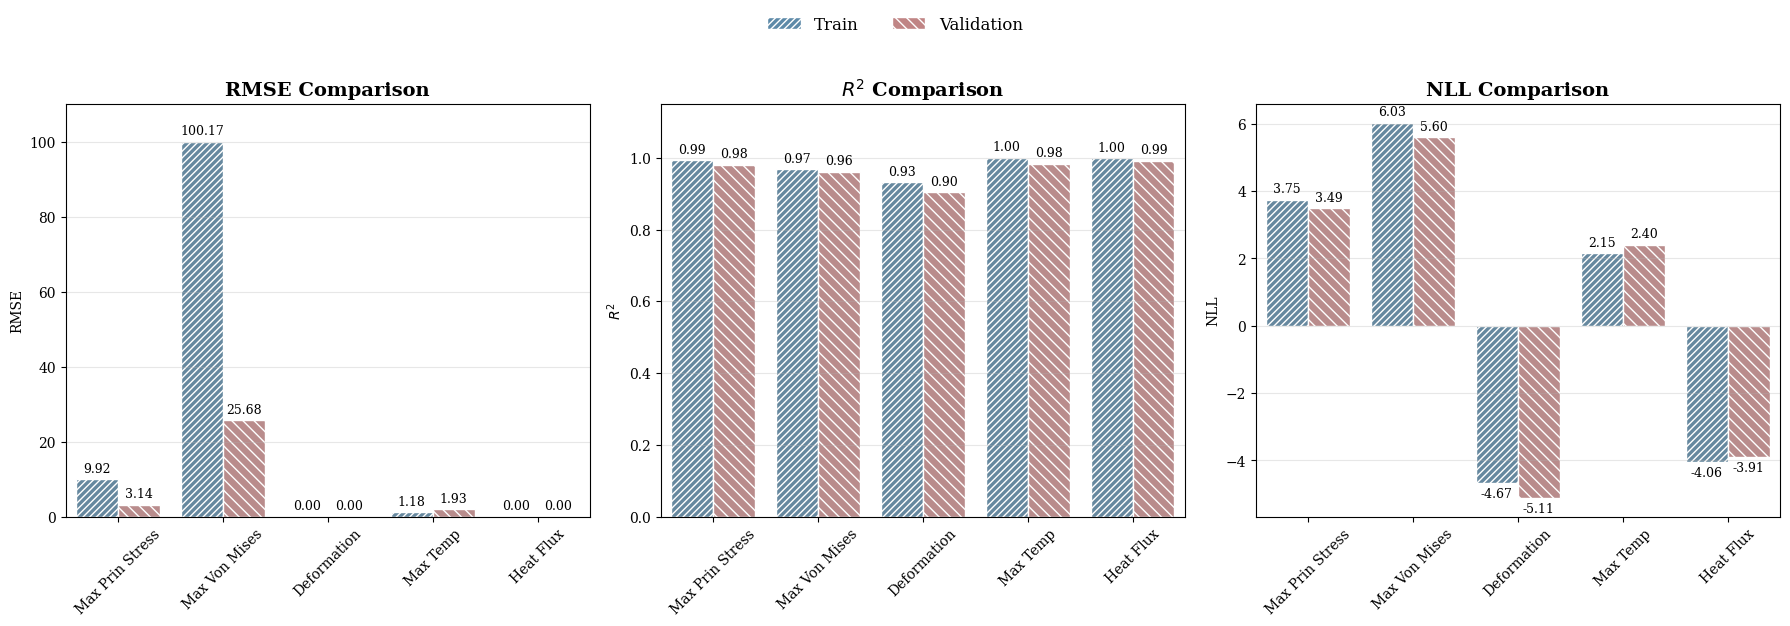

In [3]:
import pandas as pd
import numpy as np
import torch
import gpytorch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ==========================================
# 1. DATA INGESTION
# ==========================================
csv_content = """Run,Material,Power_W/mm2,Speed_mm/s,Radius_mm,Y1_Max_Prin_Stress (MPa),Y2_Max_Von_Mises,Y3_Deformation mm,Max Temp,Heat flux
1,CoCrFeNiMn ,137.27,5.31,1.44,355.95,1360.2,0.0172,255.24,0.4193
2,CoCrFeNiMn ,260.59,39.51,1.11,43.22,215.36,0.0027,58.48,0.0933
3,CoCrFeNiMn ,183.35,21.1,1.22,70.385,339.24,0.0042,79.584,0.1412
4,CoCrFeNiMn ,56.31,32.79,0.89,7.3,36.37,0.0005,28.17,0.0158
5,CoCrFeNiMn ,86.3,22.69,1.06,22.986,112.5,0.0014,41.09,0.0474
6,CoCrFeNiMn ,217.8,33.32,1.4,67.52,336.46,0.0042,78.97,0.1449
7,CoCrFeNiMn ,289.23,16.03,0.92,86.55,403.25,0.005,90.65,0.1651
8,CoCrFeNiMn ,169.14,49.17,1.27,29.557,147.42,0.0018,46.94,0.0649
9,CoCrFeNiMn ,147.07,16.71,0.94,43.89,204.7,0.0025,56.82,0.0838
10,CoCrFeNiMn ,282.05,28.76,1.29,0,0,0,22,0
11,AlCoCrFeNi,137.27,5.31,1.44,405.6,1982.7,0.031,254.83,0.4175
12,AlCoCrFeNi,260.59,39.51,1.11,57.721,310.92,0.005,58.41,0.093
13,AlCoCrFeNi,183.35,21.1,1.22,90.92,490.46,0.0078,79.47,0.1407
14,AlCoCrFeNi,56.31,32.79,0.89,9.65,51.98,0.0008,28.09,0.0156
15,AlCoCrFeNi,86.3,22.69,1.06,30.148,162.61,0.0026,41.06,0.0472
16,AlCoCrFeNi,217.8,33.32,1.4,90.2,485.68,0.0078,78.86,0.1444
17,AlCoCrFeNi,289.23,16.03,0.92,108.03,583.96,0.0092,90.52,0.1645
18,AlCoCrFeNi,169.14,49.17,1.27,39.49,212.61,0.0034,46.9,0.0646
19,AlCoCrFeNi,147.07,16.71,0.94,58.84,296.28,0.0047,56.75,0.0835
20,AlCoCrFeNi,282.05,28.76,1.29,0,0,0,22,0
21,FeCrNiTiAl,137.27,5.31,1.44,404.89,1980.9,0.0311,254.88,0.4171
22,FeCrNiTiAl,260.59,39.51,1.11,54.462,310.64,0.005,58.42,0.093
23,FeCrNiTiAl,183.35,21.1,1.22,58.788,490.1,0.0078,79.48,0.1406
24,FeCrNiTiAl,56.31,32.79,0.89,9.1938,52.51,0.0008,28.16,0.0158
25,FeCrNiTiAl,86.3,22.69,1.06,28.446,162.46,0.0026,41.06,0.0472
26,FeCrNiTiAl,217.8,33.32,1.4,85.11,485.24,0.0078,78.87,0.1444
27,FeCrNiTiAl,289.23,16.03,0.92,101.94,583.43,0.0093,90.532,0.1644
28,FeCrNiTiAl,169.14,49.17,1.27,37.258,212.41,0.0034,46.9,0.0646
29,FeCrNiTiAl,147.07,16.71,0.94,51.748,296.01,0.0047,56.76,0.0834
30,FeCrNiTiAl,282.05,28.76,1.29,0,0,0,22,0
31,NbSiTaTiZr,137.27,5.31,1.44,402.62,1985.1,0.0309,255.76,0.4206
32,NbSiTaTiZr,260.59,39.51,1.11,53.92,311.33,0.0049,58.57,0.0936
33,NbSiTaTiZr,183.35,21.1,1.22,70.41,407.24,0.0065,69.87,0.1175
34,NbSiTaTiZr,56.31,32.79,0.89,9.01,52.05,0.0008,28.12,0.0157
35,NbSiTaTiZr,86.3,22.69,1.06,24.83,134.91,0.0022,37.77,0.0326
36,NbSiTaTiZr,217.8,33.32,1.4,84.27,486.33,0.0077,79.1,0.1453
37,NbSiTaTiZr,289.23,16.03,0.92,100.84,584.51,0.0092,90.78,0.1654
38,NbSiTaTiZr,169.14,49.17,1.27,36.89,212.89,0.0034,47,0.065
39,NbSiTaTiZr,147.07,16.71,0.94,51.19,296.55,0.0047,56.88,0.0839
40,NbSiTaTiZr,282.05,28.76,1.29,0,0,0,22,0
41,HfNbTiZr,137.27,5.31,1.44,404.99,1990.7,0.0311,256.07,0.4218
42,HfNbTiZr,260.59,39.51,1.11,55.88,312.25,0.005,58.62,0.0938
43,HfNbTiZr,183.35,21.1,1.22,87.98,492.33,0.0078,79.77,0.1418
44,HfNbTiZr,56.31,32.79,0.89,9.34,52.2,0.0008,28.12,0.0157
45,HfNbTiZr,86.3,22.69,1.06,29.182,163.3,0.0026,41.165,0.0476
46,HfNbTiZr,217.8,33.32,1.4,87.193,487.08,0.0078,79.1,0.1455
47,HfNbTiZr,289.23,16.03,0.92,104.53,586.2,0.0093,90.88,0.1658
48,HfNbTiZr,169.14,49.17,1.27,38.227,213.52,0.0034,47.04,0.0652
49,HfNbTiZr,147.07,16.71,0.94,53.06,297.41,0.0047,56.93,0.0841
50,HfNbTiZr,282.05,28.76,1.29,0,0,0,22,0
"""
df = pd.read_csv(io.StringIO(csv_content))
df['Material'] = df['Material'].str.strip()
df_clean = df[(df['Y2_Max_Von_Mises'] > 1e-6) & (df['Heat flux'] > 1e-6)].copy()

# ==========================================
# 2. FEATURE ENGINEERING & SPLIT
# ==========================================
material_props = {
    'CoCrFeNiMn': [8250, 12.5, 425],
    'AlCoCrFeNi': [8000, 15.0, 445],
    'FeCrNiTiAl': [8100, 15.0, 435],
    'NbSiTaTiZr': [8350, 10.0, 405],
    'HfNbTiZr':   [8450, 8.5,  395]
}
props_df = pd.DataFrame(df_clean['Material'].map(material_props).tolist(),
                        index=df_clean.index, columns=['Density', 'Conductivity', 'Cp'])
process_params = ['Power_W/mm2', 'Speed_mm/s', 'Radius_mm']
output_cols = ['Y1_Max_Prin_Stress (MPa)', 'Y2_Max_Von_Mises', 'Y3_Deformation mm', 'Max Temp', 'Heat flux']
labels = ['Max Prin Stress', 'Max Von Mises', 'Deformation', 'Max Temp', 'Heat Flux']

X_data = pd.concat([df_clean[process_params], props_df], axis=1)
y_data = df_clean[output_cols]

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

X_scaler = MinMaxScaler()
y_scaler = StandardScaler()

X_train = torch.tensor(X_scaler.fit_transform(X_train_raw), dtype=torch.float32)
y_train = torch.tensor(y_scaler.fit_transform(y_train_raw), dtype=torch.float32)
X_val = torch.tensor(X_scaler.transform(X_val_raw), dtype=torch.float32)
y_val = torch.tensor(y_scaler.transform(y_val_raw), dtype=torch.float32)

# ==========================================
# 3. MOGP MODEL
# ==========================================
class MOGP_Surrogate(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MOGP_Surrogate, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(gpytorch.means.ConstantMean(), num_tasks=5)
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=6)),
            num_tasks=5, rank=1
        )
    def forward(self, x):
        return gpytorch.distributions.MultitaskMultivariateNormal(self.mean_module(x), self.covar_module(x))

print("Training MOGP on 80% split...")
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=5)
model = MOGP_Surrogate(X_train, y_train, likelihood)
model.train(); likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    optimizer.zero_grad()
    loss = -mll(model(X_train), y_train)
    loss.backward()
    optimizer.step()

# ==========================================
# 4. METRIC CALCULATION
# ==========================================
model.eval(); likelihood.eval()

def compute_metrics(X, y_true_scaled, dataset_name):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        dist = likelihood(model(X))
        y_pred = y_scaler.inverse_transform(dist.mean.numpy())
        y_true = y_scaler.inverse_transform(y_true_scaled.numpy())
        y_var = dist.variance.numpy() * (y_scaler.scale_ ** 2)

    metrics = []
    for i, col in enumerate(labels):
        rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        nll_vals = 0.5 * (np.log(2 * np.pi * y_var[:, i]) + (y_true[:, i] - y_pred[:, i])**2 / y_var[:, i])
        nll = np.mean(nll_vals)
        metrics.append({'Dataset': dataset_name, 'Output': col, 'RMSE': rmse, '$R^2$': r2, 'NLL': nll})
    return metrics

train_metrics = compute_metrics(X_train, y_train, 'Train')
val_metrics = compute_metrics(X_val, y_val, 'Validation')
df_metrics = pd.DataFrame(train_metrics + val_metrics)

# ==========================================
# 5. VISUALIZATION (STYLED + LABELS + GLOBAL LEGEND)
# ==========================================
plt.rcParams["font.family"] = "serif"
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

soothing_colors = ['#5D8AA8', '#C08585'] # Slate Blue, Dusty Rose
hatches = ['/////', '\\\\\\']
metric_types = ['RMSE', '$R^2$', 'NLL']

# Create Custom Legend Handles
legend_handles = [
    mpatches.Patch(facecolor=soothing_colors[0], hatch=hatches[0], label='Train', edgecolor='white'),
    mpatches.Patch(facecolor=soothing_colors[1], hatch=hatches[1], label='Validation', edgecolor='white')
]

for i, metric in enumerate(metric_types):
    sns.barplot(data=df_metrics, x='Output', y=metric, hue='Dataset',
                ax=axes[i], palette=soothing_colors)

    # Apply Hatches, White Edges, and Add Labels
    for j, container in enumerate(axes[i].containers):
        # 1. Hatches and Edges
        for patch in container:
            patch.set_hatch(hatches[j % len(hatches)])
            patch.set_edgecolor('white')
            patch.set_linewidth(1)

        # 2. Add Value Labels (The New Request)
        # padding=3 adds distance from the bar end
        axes[i].bar_label(container, fmt='%.2f', padding=3, fontsize=9)

    axes[i].set_title(f'{metric} Comparison', fontsize=14, weight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('')
    axes[i].grid(axis='y', alpha=0.3)

    # 3. Adjust Y-limits to fit labels for R2 (since bars are near 1.0)
    if metric == '$R^2$':
        axes[i].set_ylim(0, 1.15) # Give 15% headroom for text
    elif metric == 'RMSE':
         # Auto scale usually works, but adding slight margin helps
         y_max = df_metrics[df_metrics['Dataset'].isin(['Train','Validation']) &
                            (df_metrics['Output'].isin(labels))]['RMSE'].max()
         axes[i].set_ylim(0, y_max * 1.1)

    # Remove local legend
    if axes[i].legend_:
        axes[i].legend_.remove()

# Add Single Global Legend
fig.legend(handles=legend_handles, loc='upper center',
           bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('train_val_metrics_comparison_final.pdf', format='pdf', dpi=300, bbox_inches='tight')
print("\n>> Saved comparison plot to 'train_val_metrics_comparison_final.pdf'")
plt.show()